# LSTM TRAINING


The notebook implements LSTM (Long Short-Term Memory) training for cryptocurrency price prediction. The data is collected from the Coinbase Market API, aggregated at 15-minute intervals for the top 11 cryptocurrencies, and spans the time range from 2020 to January 26, 2025.

LSTM is used to capture sequential dependencies in the price data for predicting future price trends.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import pickle
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping

## Processing Data

### Function: `load_and_preprocess_data`

This function:
1. Loads the CSV dataset and filters it for a specific cryptocurrency (`product_id`).
2. Sorts the data chronologically by `time`.
3. Adds technical indicators:
   - **SMA (Simple Moving Average)**: Average closing price over a specified time window.
   - **EMA (Exponential Moving Average)**: Weighted average favoring recent data.
4. Handles missing values using backfill (`bfill`).


In [3]:
def load_and_preprocess_data(csv_path, product_id):
    df = pd.read_csv(csv_path)
    product_data = df[df['product_id'] == product_id].drop_duplicates()
    product_data = product_data.sort_values(by=['time'])
    product_data['time'] = pd.to_datetime(product_data['time'])

    product_data['SMA_7'] = product_data['close'].rolling(window=7).mean()
    product_data['EMA_7'] = product_data['close'].ewm(span=7, adjust=False).mean()
    product_data['SMA_30'] = product_data['close'].rolling(window=30).mean()
    product_data['EMA_30'] = product_data['close'].ewm(span=30, adjust=False).mean()

    product_data.fillna(method='bfill', inplace=True)
    return product_data

### Function: `create_sequences`

This function creates sequences for LSTM:
- **Input Features (`X`)**: Uses the last `sequence_length` timesteps.
- **Target (`y`)**: The value immediately following the sequence.
- **Dates (`date_seq`)**: Corresponding dates for each sequence.


In [4]:

def create_sequences(features, target, dates, sequence_length):
    X, y, date_seq = [], [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i + sequence_length])
        date_seq.append(dates[i + sequence_length])
    return np.array(X), np.array(y), np.array(date_seq)

### Function: `split_and_scale_data`

This function:
1. Splits data into training (80%) and testing (20%) sets.
2. Scales input and target data to a 0–1 range using `MinMaxScaler`.
3. Returns the scaled data along with train/test splits and scalers for future use.


In [5]:


def split_and_scale_data(features, target, dates, sequence_length):
    X, y, dates = create_sequences(features.values, target.values, dates.values, sequence_length)

    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    dates_train, dates_test = dates[:train_size], dates[train_size:]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, dates_train, dates_test, scaler_X, scaler_y

## Building and Training the LSTM Model

### Function: `build_and_train_model`

This function:
1. **Builds the LSTM Model**:
   - Two LSTM layers (each with 50 units) to capture sequential dependencies.
   - Dropout layers (0.2) for regularization.
   - A Dense layer with one output node for predictions.
2. **Compiles the Model**:
   - Optimizer: `Adam` (adaptive optimization).
   - Loss Function: Mean Squared Error (`MSE`).
3. **Trains the Model**:
   - Early stopping is used to stop training if validation loss does not improve for 5 consecutive epochs.


In [6]:
def build_and_train_model(X_train, y_train, X_test, y_test, sequence_length, epochs, batch_size):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size,
        validation_split=0.2, verbose=1, callbacks=[early_stopping]
    )

    return model

In [7]:

def save_model_and_scalers(model, scaler_X, scaler_y, product_id, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, f"model_{product_id}.h5")
    save_model(model, model_path)

    with open(os.path.join(save_dir, f"scaler_X_{product_id}.pkl"), 'wb') as f:
        pickle.dump(scaler_X, f)
    with open(os.path.join(save_dir, f"scaler_y_{product_id}.pkl"), 'wb') as f:
        pickle.dump(scaler_y, f)

## Model Evaluation

### Function: `make_predictions_and_save`

This function:
1. Predicts prices on the test set.
2. Rescales predictions and test targets to their original scale using `MinMaxScaler`.
3. Calculates Root Mean Squared Error (RMSE) as a metric to evaluate the model’s performance.
4. Saves predictions and RMSE to disk for further analysis.


In [8]:
def make_predictions_and_save(X_test, y_test, dates_test, scaler_y, product_id, save_dir, model):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_rescaled = scaler_y.inverse_transform(y_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred))
    print(f"RMSE for Product {product_id}: {rmse}")

    rmse_file_path = os.path.join(save_dir, "rmse_summary.txt")
    with open(rmse_file_path, "a") as f:
        f.write(f"Product ID: {product_id}, RMSE: {rmse:.4f}\n")


    predictions_df = pd.DataFrame({
        'Date': dates_test,
        'Actual': y_test_rescaled.flatten(),
        'Prediction': y_pred.flatten()
    })

    predictions_path = os.path.join(save_dir, f"predictions_{product_id}.csv")
    predictions_df.to_csv(predictions_path, index=False)

    return predictions_df, rmse

## Visualization

### Function: `plot_results`

This function visualizes:
1. Training data.
2. Testing data.
3. Predicted values on the same plot.



In [9]:

def plot_results(dates_train, y_train, dates_test, y_test, y_pred, product_id):
    plt.figure(figsize=(12, 6))

    plt.plot(dates_train, y_train, label='Training Data', color='blue')
    plt.plot(dates_test, y_test, label='Testing Data', color='orange')
    plt.plot(dates_test, y_pred, label='Predictions', color='green')

    plt.title(f'Training and Testing Data with Predictions for Product {product_id}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.plot(dates_test[-24:], y_test[-24:], label='Testing Data', color='orange')
    # plt.plot(dates_test[-24:], y_pred[-24:], label='Predictions', color='green')

    # plt.title(f'Last 24 Points: Testing Data with Predictions for Product {product_id}')
    # plt.xlabel('Date')
    # plt.ylabel('Close Price')
    # plt.legend()
    # plt.xticks(rotation=45)
    # plt.show()



### Function: `plot_with_plotly`

This function uses Plotly to create interactive visualizations of:
1. Testing data (actual prices).
2. Predicted prices (model output).

In [10]:
def plot_with_plotly(dates_test, y_test_rescaled, y_pred):
    fig = go.Figure()

    # Add testing data
    fig.add_trace(go.Scatter(
        x=dates_test[-24:], 
        y=y_test_rescaled[-24:].flatten(), 
        mode='lines+markers', 
        name='Testing Data', 
        line=dict(color='orange'),
        marker=dict(symbol='circle', size=6)
    ))

    # Add predictions
    fig.add_trace(go.Scatter(
        x=dates_test[-24:], 
        y=y_pred[-24:], 
        mode='lines+markers', 
        name='Predictions', 
        line=dict(color='green'),
        marker=dict(symbol='circle', size=6)
    ))

    # Update layout
    fig.update_layout(
        title='Testing Data with Predictions (Last 24 Points)',
        xaxis_title='Date',
        yaxis_title='Close Price',
        xaxis=dict(
            showgrid=True,
            tickformat='%Y-%m-%d %H:%M',
            tickangle=45
        ),
        yaxis=dict(showgrid=True),
        legend=dict(orientation='h', x=0.5, xanchor='center', y=-0.2)
    )

    fig.show()

In [11]:
def save_rmse_to_file(product_id, rmse, save_dir):
    rmse_file_path = os.path.join(save_dir, "rmse_summary.txt")
    with open(rmse_file_path, "a") as f:
        f.write(f"Product ID: {product_id}, RMSE: {rmse:.4f}\n")



## Running the Pipeline

### Function: `run_pipeline_for_all_products`

This function automates the pipeline for all cryptocurrencies in the dataset:
1. Loads and preprocesses data for each `product_id`.
2. Splits and scales the data.
3. Trains an LSTM model on the training set.
4. Evaluates the model using RMSE on the test set.
5. Saves the trained model, scalers, and predictions.
6. Visualizes the results using both Matplotlib and Plotly.


 Sequence Length: 192
1. The sequence_length parameter defines how many past timesteps are used for prediction.
2. With 15-minute data, 192 timesteps represent 48 hours of historical data.
3. This provides enough context to capture short-term trends while balancing computational efficiency.

Processing Product: ADA-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  product_data.fillna(method='bfill', inplace=True)


Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 79s 59ms/step - loss: 0.0014 - val_loss: 8.4782e-05
Epoch 2/15
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - loss: 5.0378e-04 - val_loss: 1.6252e-04
Epoch 3/15
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 73s 55ms/step - loss: 4.0466e-04 - val_loss: 6.7114e-05
Epoch 4/15
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - loss: 3.7186e-04 - val_loss: 2.9698e-05
Epoch 5/15
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - loss: 3.6282e-04 - val_loss: 9.4801e-05
Epoch 6/15
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 74s 56ms/step - loss: 3.5315e-04 - val_loss: 1.7934e-04
Epoch 7/15
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - loss: 3.5419e-04 - val_loss: 8.0085e-05
Epoch 8/15
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 74s 56ms/step - loss: 3.3100e-04 - val_loss: 2.7591e-04
Epoch 9/15
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 74s 56ms/step - loss: 3.3609e-04 - val_loss: 3.2147e-05


414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
RMSE for Product ADA-USD: 0.01250046207766479


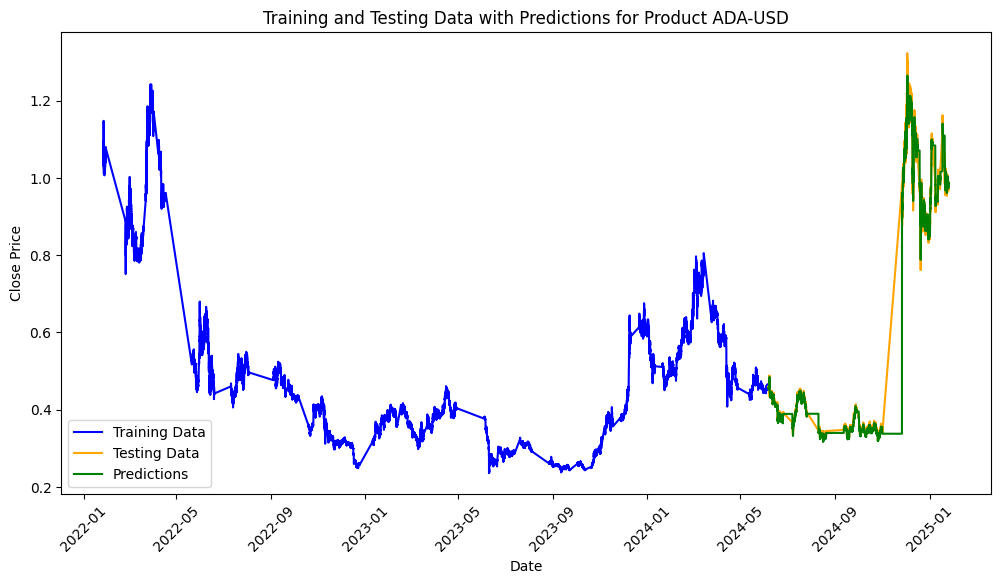

Processing Product: DOT-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1370/1370 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - loss: 0.0026 - val_loss: 6.5439e-05
Epoch 2/15
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 73s 53ms/step - loss: 5.3362e-04 - val_loss: 2.0281e-05
Epoch 3/15
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 4.1161e-04 - val_loss: 1.1448e-05
Epoch 4/15
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - loss: 4.1065e-04 - val_loss: 1.4961e-05
Epoch 5/15
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - loss: 3.8906e-04 - val_loss: 2.0410e-05
Epoch 6/15
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - loss: 3.9477e-04 - val_loss: 1.2294e-05
Epoch 7/15
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - loss: 3.8353e-04 - val_loss: 1.2926e-05
Epoch 8/15
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - loss: 3.7666e-04 - val_loss: 1.4635e-05


429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
RMSE for Product DOT-USD: 0.11239923314713164


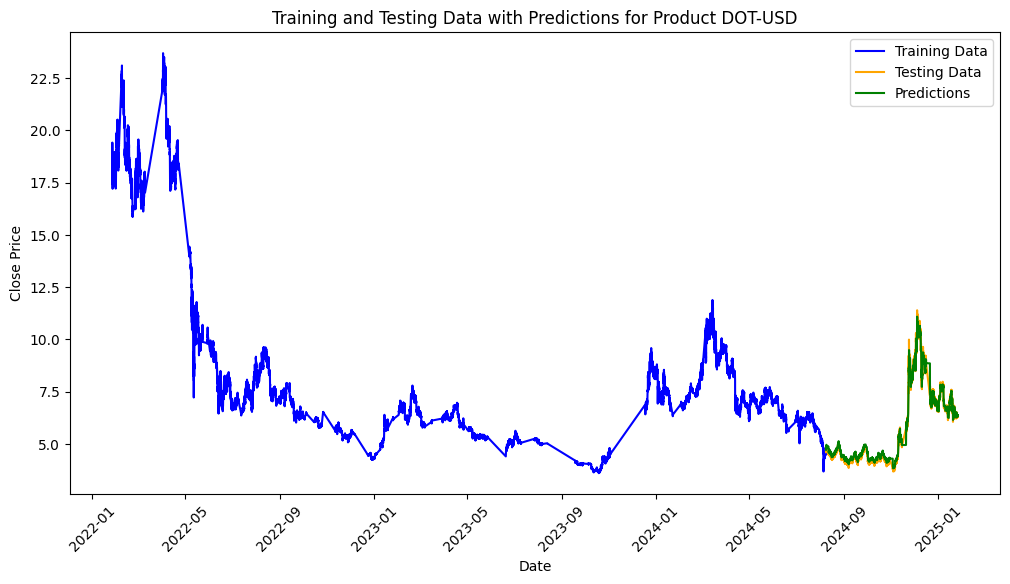

Processing Product: ETH-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1308/1308 ━━━━━━━━━━━━━━━━━━━━ 70s 53ms/step - loss: 0.0031 - val_loss: 1.8204e-04
Epoch 2/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step - loss: 4.1883e-04 - val_loss: 7.0637e-04
Epoch 3/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 70s 54ms/step - loss: 2.7546e-04 - val_loss: 1.9982e-04
Epoch 4/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 69s 53ms/step - loss: 2.4588e-04 - val_loss: 1.0317e-04
Epoch 5/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 2.1243e-04 - val_loss: 4.1703e-04
Epoch 6/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 2.1500e-04 - val_loss: 1.1230e-04
Epoch 7/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 2.1257e-04 - val_loss: 1.1053e-04
Epoch 8/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 2.0140e-04 - val_loss: 2.1576e-04
Epoch 9/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 2.1320e-04 - val_loss: 9.1259e-04


409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
RMSE for Product ETH-USD: 37.8910110764059


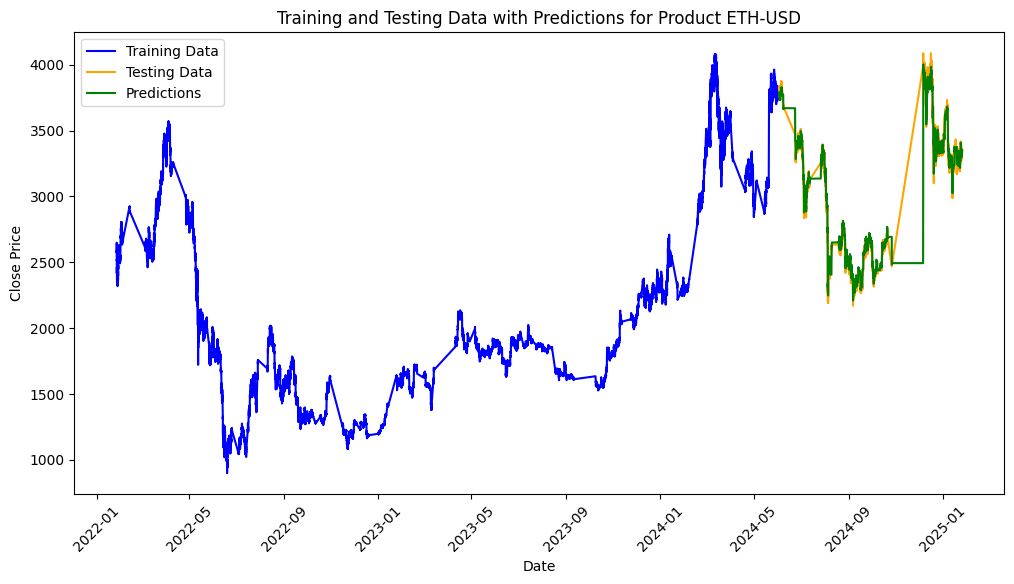

Processing Product: BAT-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1390/1390 ━━━━━━━━━━━━━━━━━━━━ 74s 52ms/step - loss: 0.0022 - val_loss: 4.7844e-05
Epoch 2/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 6.0536e-04 - val_loss: 1.4204e-05
Epoch 3/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 5.3158e-04 - val_loss: 1.3732e-05
Epoch 4/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 5.1380e-04 - val_loss: 1.8595e-05
Epoch 5/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - loss: 4.5544e-04 - val_loss: 2.0675e-05
Epoch 6/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 4.8019e-04 - val_loss: 4.1513e-05
Epoch 7/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 4.5338e-04 - val_loss: 9.7563e-06
Epoch 8/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 4.8427e-04 - val_loss: 1.2492e-05
Epoch 9/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 4.6980e-04 - val_loss: 7.4142e-06
Epoch 10/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 4.1854e-04 - val_loss: 3.6497e-05
Epoch 11/15
1390/1390 ━━━━━━━━━━━━

435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
RMSE for Product BAT-USD: 0.0021878038796451916


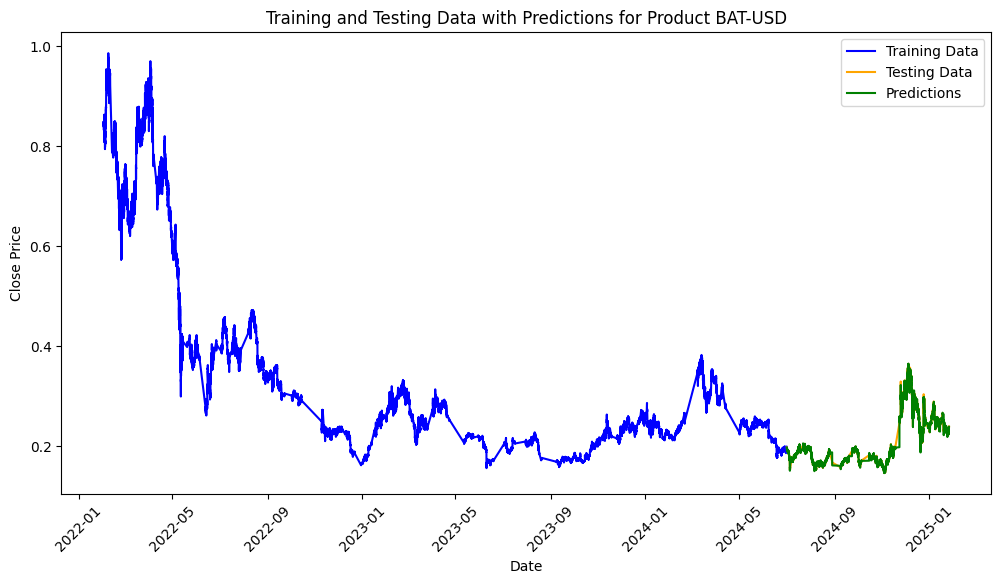

Processing Product: BTC-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1348/1348 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 2/15
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 2.6332e-04 - val_loss: 0.0019
Epoch 3/15
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 1.7183e-04 - val_loss: 0.0026
Epoch 4/15
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 1.5231e-04 - val_loss: 0.0019
Epoch 5/15
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 1.5599e-04 - val_loss: 0.0031
Epoch 6/15
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 1.4677e-04 - val_loss: 0.0047
Epoch 7/15
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 1.4826e-04 - val_loss: 0.0066
Epoch 8/15
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 71s 53ms/step - loss: 1.5201e-04 - val_loss: 0.0103
Epoch 9/15
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 73s 54ms/step - loss: 1.4172e-04 - val_loss: 0.0093


422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
RMSE for Product BTC-USD: 11302.338745068633


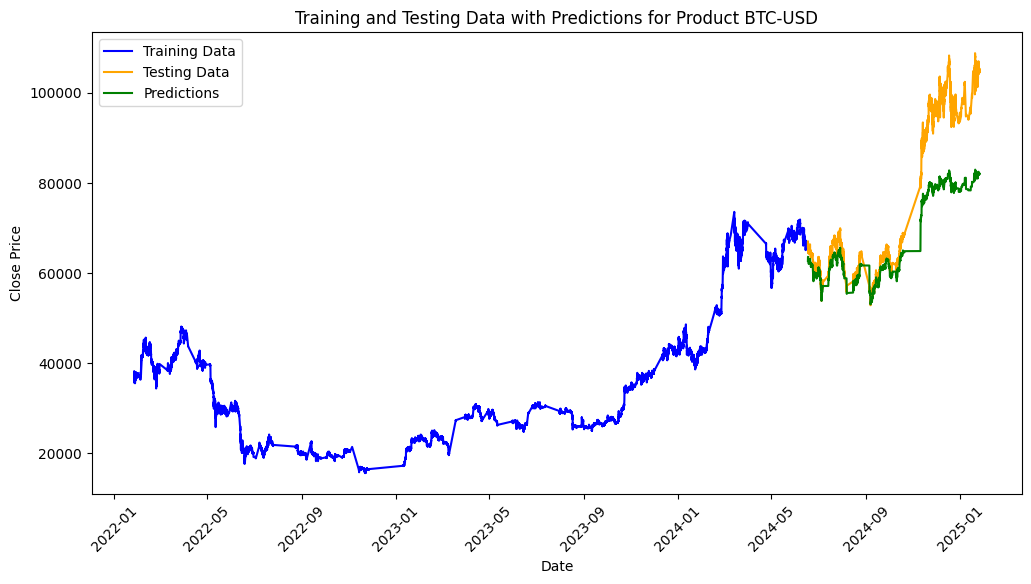

Processing Product: DOGE-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1295/1295 ━━━━━━━━━━━━━━━━━━━━ 70s 54ms/step - loss: 0.0013 - val_loss: 4.9790e-04
Epoch 2/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 4.0622e-04 - val_loss: 8.6956e-04
Epoch 3/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 2.9883e-04 - val_loss: 2.3707e-04
Epoch 4/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 3.0339e-04 - val_loss: 2.2587e-04
Epoch 5/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 69s 53ms/step - loss: 2.5821e-04 - val_loss: 1.8436e-04
Epoch 6/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 69s 53ms/step - loss: 2.6826e-04 - val_loss: 2.0221e-04
Epoch 7/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 69s 53ms/step - loss: 2.5974e-04 - val_loss: 3.0884e-04
Epoch 8/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 2.5153e-04 - val_loss: 3.4463e-04
Epoch 9/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 2.4305e-04 - val_loss: 3.8317e-04
Epoch 10/15
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 2.4017e-04 - val_loss: 4.0610e-04


405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
RMSE for Product DOGE-USD: 0.07933696004865708


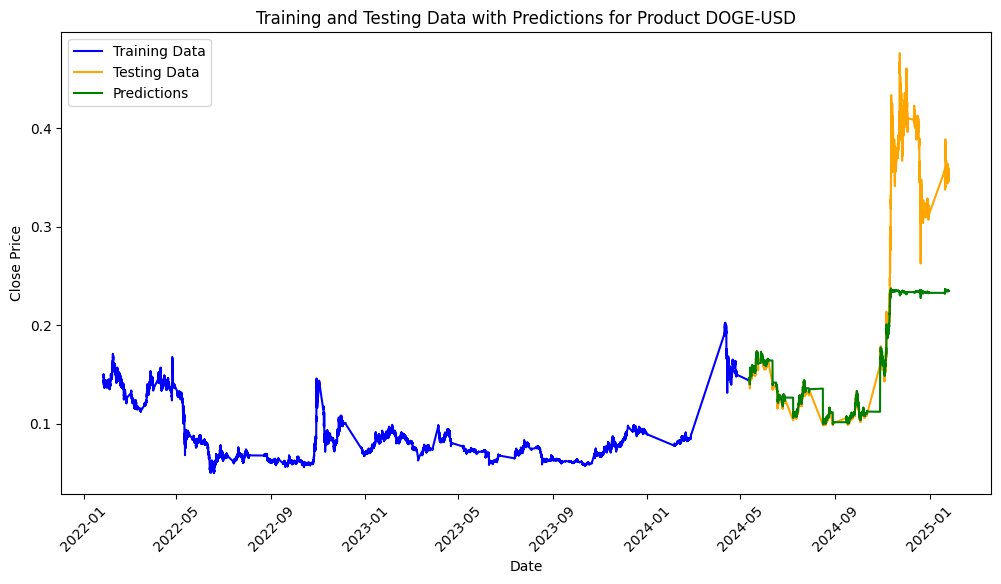

Processing Product: BTRST-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1216/1216 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - loss: 0.0039 - val_loss: 1.4680e-05
Epoch 2/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 64s 53ms/step - loss: 7.4111e-04 - val_loss: 1.7402e-05
Epoch 3/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 65s 54ms/step - loss: 5.9017e-04 - val_loss: 1.6709e-05
Epoch 4/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step - loss: 5.1139e-04 - val_loss: 2.8358e-05
Epoch 5/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 64s 53ms/step - loss: 5.3818e-04 - val_loss: 8.8828e-06
Epoch 6/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 64s 52ms/step - loss: 4.7888e-04 - val_loss: 4.1976e-05
Epoch 7/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 64s 53ms/step - loss: 4.9475e-04 - val_loss: 1.3658e-05
Epoch 8/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step - loss: 4.8964e-04 - val_loss: 6.7513e-06
Epoch 9/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step - loss: 4.8347e-04 - val_loss: 8.4747e-06
Epoch 10/15
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step - loss: 5.2047e-04 - val_loss: 1.6465e-05
Epoch 11/15
1216/1216 ━━━━━━━━━━━━

380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
RMSE for Product BTRST-USD: 0.025540293551289894


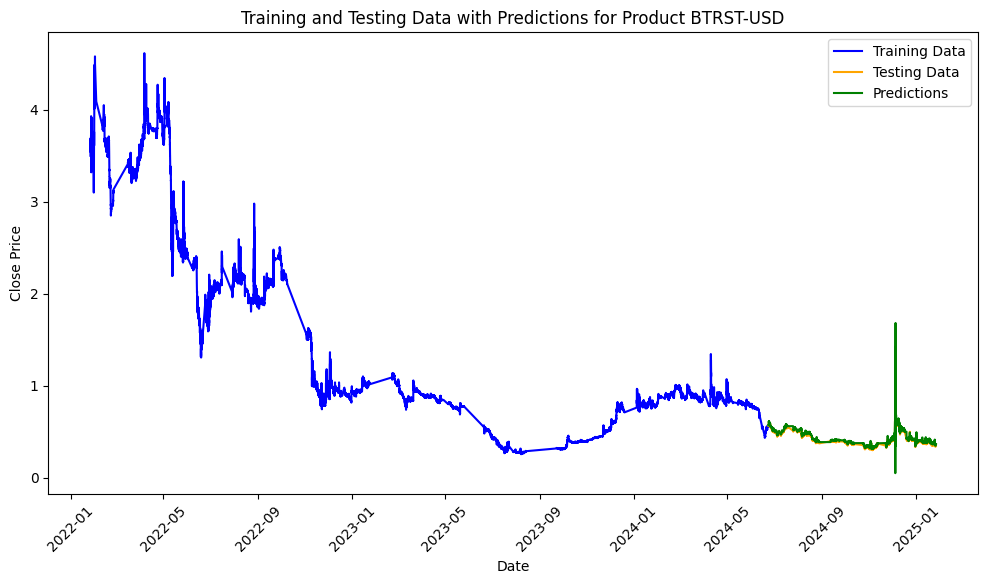

Processing Product: ATOM-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1301/1301 ━━━━━━━━━━━━━━━━━━━━ 69s 52ms/step - loss: 0.0032 - val_loss: 1.1850e-05
Epoch 2/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 6.5863e-04 - val_loss: 7.9355e-06
Epoch 3/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 4.8483e-04 - val_loss: 7.8735e-05
Epoch 4/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 4.3868e-04 - val_loss: 5.2349e-06
Epoch 5/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 4.0292e-04 - val_loss: 5.1205e-06
Epoch 6/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 4.0028e-04 - val_loss: 5.3697e-06
Epoch 7/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 3.9118e-04 - val_loss: 3.4805e-05
Epoch 8/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 3.8041e-04 - val_loss: 4.8693e-06
Epoch 9/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 3.9081e-04 - val_loss: 8.8300e-06
Epoch 10/15
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 3.8019e-04 - val_loss: 1.2089e-05
Epoch 11/15
1301/1301 ━━━━━━━━━━━━

407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
RMSE for Product ATOM-USD: 0.08448566361980933


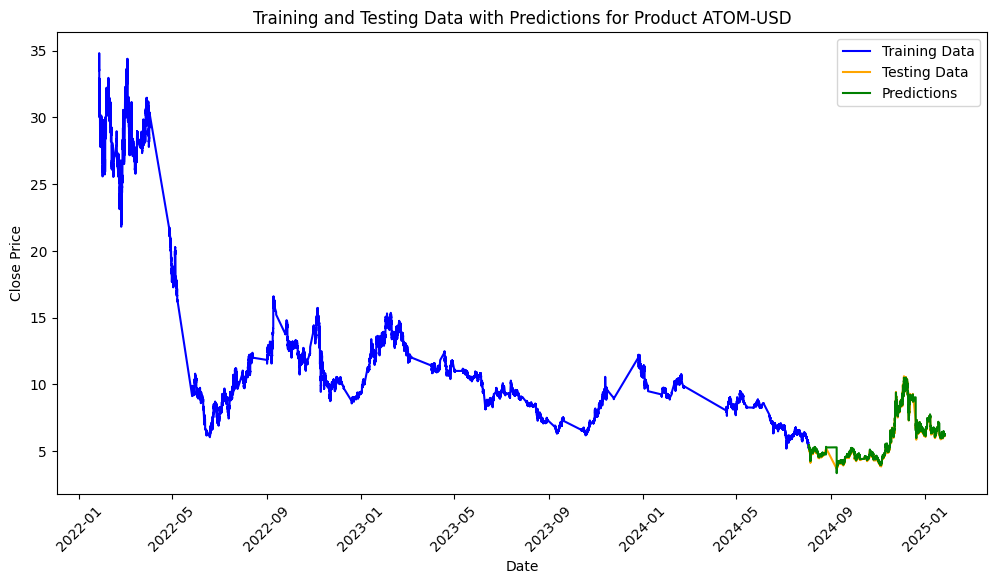

Processing Product: LINK-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1385/1385 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - loss: 0.0027 - val_loss: 9.3285e-04
Epoch 2/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - loss: 4.4253e-04 - val_loss: 3.3954e-04
Epoch 3/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 73s 53ms/step - loss: 3.5460e-04 - val_loss: 4.2442e-04
Epoch 4/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 3.3499e-04 - val_loss: 4.7678e-04
Epoch 5/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 3.1661e-04 - val_loss: 3.2087e-04
Epoch 6/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 3.1038e-04 - val_loss: 2.5049e-04
Epoch 7/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 3.0135e-04 - val_loss: 6.2655e-04
Epoch 8/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 2.9361e-04 - val_loss: 3.6672e-04
Epoch 9/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - loss: 3.0196e-04 - val_loss: 9.8249e-04
Epoch 10/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 2.8491e-04 - val_loss: 0.0013
Epoch 11/15
1385/1385 ━━━━━━━━━━━━━━━━

433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
RMSE for Product LINK-USD: 1.169417723374723


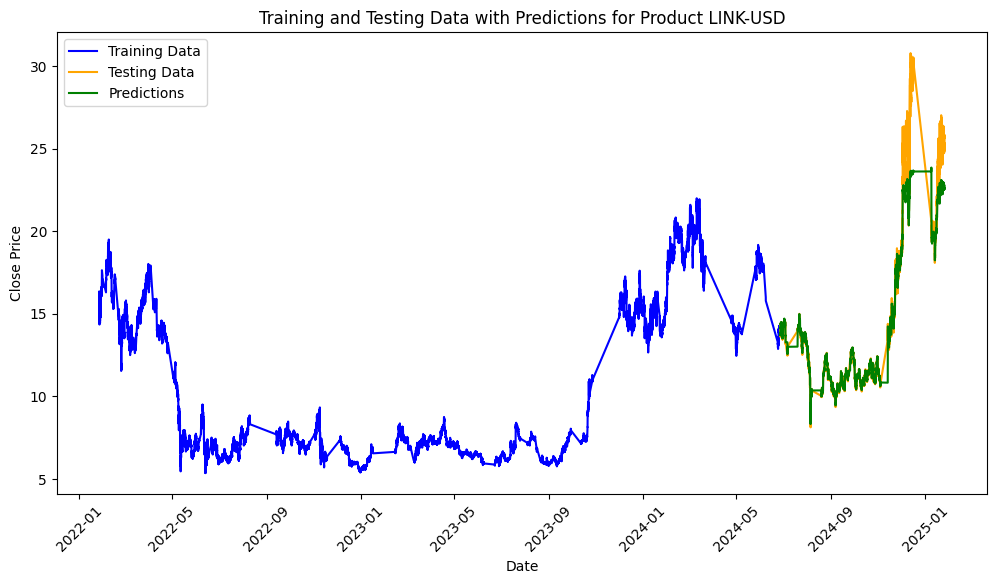

Processing Product: RAD-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1047/1047 ━━━━━━━━━━━━━━━━━━━━ 55s 52ms/step - loss: 0.0028 - val_loss: 6.6140e-05
Epoch 2/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 6.9591e-04 - val_loss: 6.5398e-05
Epoch 3/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 5.2559e-04 - val_loss: 1.0082e-04
Epoch 4/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 4.8646e-04 - val_loss: 1.2410e-04
Epoch 5/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 4.6612e-04 - val_loss: 4.4948e-05
Epoch 6/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 4.5040e-04 - val_loss: 5.9773e-05
Epoch 7/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 4.4277e-04 - val_loss: 6.1058e-05
Epoch 8/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 4.4049e-04 - val_loss: 5.2074e-05
Epoch 9/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 4.2884e-04 - val_loss: 7.3113e-05
Epoch 10/15
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - loss: 4.0412e-04 - val_loss: 3.7860e-05
Epoch 11/15
1047/1047 ━━━━━━━━━━━━

328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
RMSE for Product RAD-USD: 0.018711885956174613


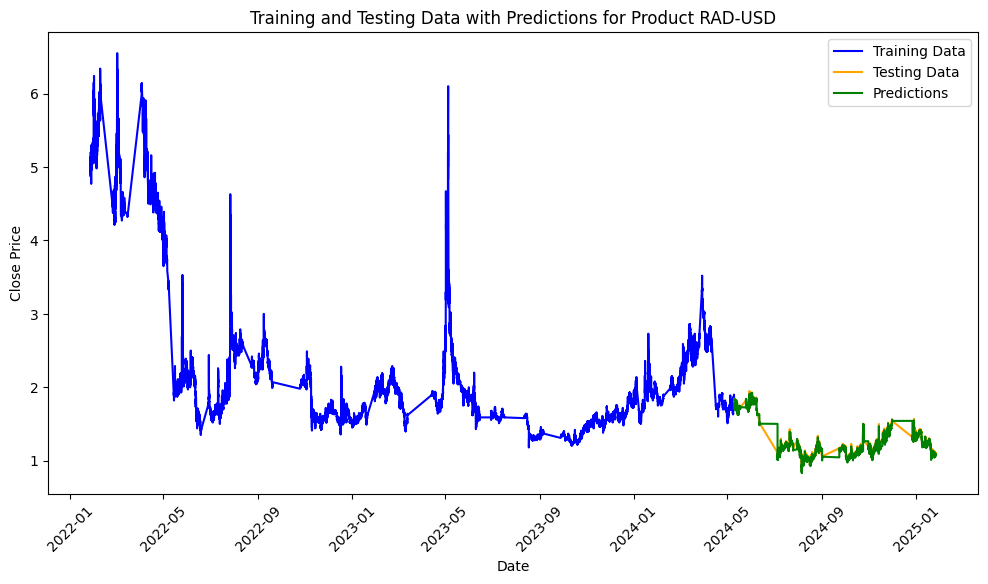

Processing Product: MANA-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1331/1331 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 0.0032 - val_loss: 2.7542e-05
Epoch 2/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 69s 52ms/step - loss: 4.9451e-04 - val_loss: 3.2872e-05
Epoch 3/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 69s 52ms/step - loss: 4.0988e-04 - val_loss: 6.1784e-06
Epoch 4/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 3.9433e-04 - val_loss: 3.9701e-05
Epoch 5/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 69s 52ms/step - loss: 4.2851e-04 - val_loss: 7.9521e-06
Epoch 6/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 3.9791e-04 - val_loss: 1.8870e-05
Epoch 7/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 3.7494e-04 - val_loss: 3.1591e-06
Epoch 8/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 3.7334e-04 - val_loss: 8.4524e-06
Epoch 9/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 3.5408e-04 - val_loss: 8.3986e-06
Epoch 10/15
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 3.5072e-04 - val_loss: 7.5706e-06
Epoch 11/15
1331/1331 ━━━━━━━━━━━━

416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
RMSE for Product MANA-USD: 0.008041865239062364


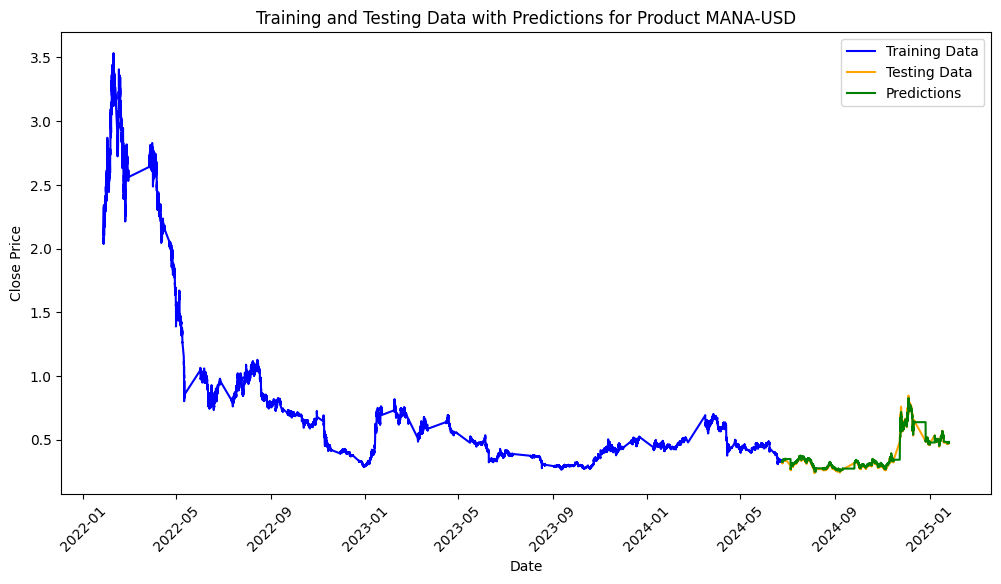

Processing Product: SUSHI-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1309/1309 ━━━━━━━━━━━━━━━━━━━━ 69s 52ms/step - loss: 0.0014 - val_loss: 4.8025e-05
Epoch 2/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 4.2526e-04 - val_loss: 9.1903e-05
Epoch 3/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 4.0558e-04 - val_loss: 3.9824e-05
Epoch 4/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - loss: 3.5661e-04 - val_loss: 2.5475e-05
Epoch 5/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 3.5842e-04 - val_loss: 3.0499e-05
Epoch 6/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 3.8257e-04 - val_loss: 1.3612e-05
Epoch 7/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 3.5520e-04 - val_loss: 1.5273e-05
Epoch 8/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 3.3193e-04 - val_loss: 9.4826e-06
Epoch 9/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 69s 52ms/step - loss: 3.3624e-04 - val_loss: 9.3056e-05
Epoch 10/15
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - loss: 5.3451e-04 - val_loss: 1.2371e-05
Epoch 11/15
1309/1309 ━━━━━━━━━━━━

409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
RMSE for Product SUSHI-USD: 0.018452974984589508


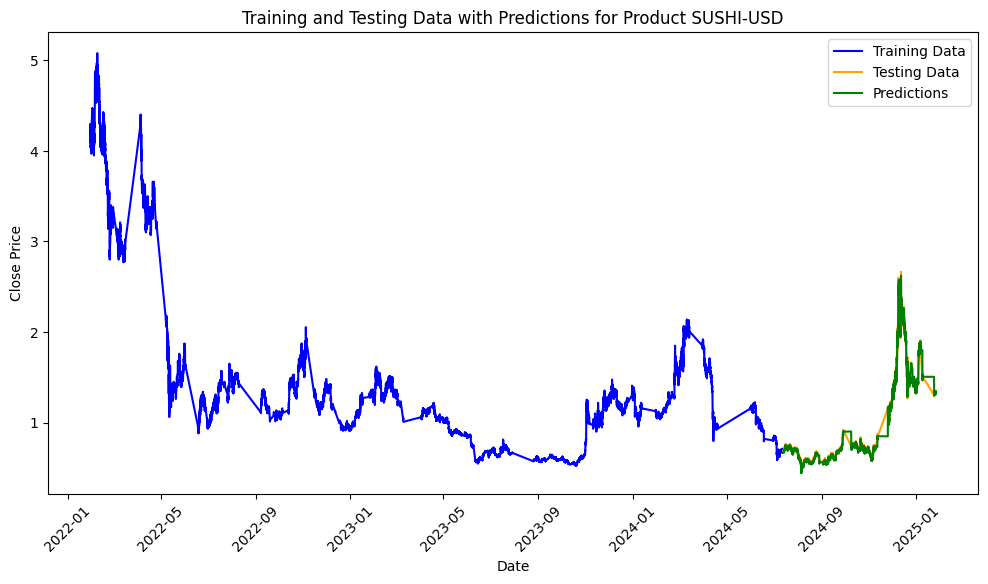

Processing Product: SOL-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1392/1392 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 2/15
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 2.4051e-04 - val_loss: 3.4048e-04
Epoch 3/15
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 1.9544e-04 - val_loss: 3.6571e-04
Epoch 4/15
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 1.7672e-04 - val_loss: 0.0013
Epoch 5/15
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 1.7336e-04 - val_loss: 3.8604e-04
Epoch 6/15
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 1.7257e-04 - val_loss: 0.0016
Epoch 7/15
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 1.7203e-04 - val_loss: 0.0014


435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
RMSE for Product SOL-USD: 10.706265638352026


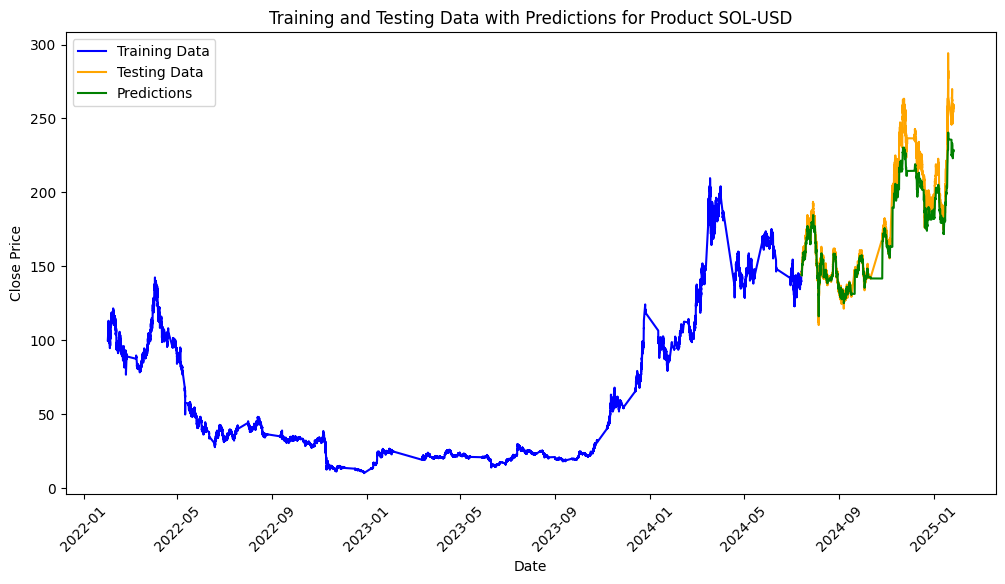

Processing Product: MATIC-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1445/1445 ━━━━━━━━━━━━━━━━━━━━ 75s 51ms/step - loss: 0.0021 - val_loss: 4.6211e-05
Epoch 2/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 76s 52ms/step - loss: 5.1097e-04 - val_loss: 3.6301e-05
Epoch 3/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 75s 52ms/step - loss: 3.6025e-04 - val_loss: 4.0792e-05
Epoch 4/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 75s 52ms/step - loss: 3.2379e-04 - val_loss: 8.2901e-05
Epoch 5/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 75s 52ms/step - loss: 3.1546e-04 - val_loss: 8.2342e-05
Epoch 6/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 77s 54ms/step - loss: 3.1808e-04 - val_loss: 6.9605e-05
Epoch 7/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 76s 53ms/step - loss: 3.2138e-04 - val_loss: 3.2452e-05
Epoch 8/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 74s 51ms/step - loss: 3.0287e-04 - val_loss: 2.2612e-05
Epoch 9/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 74s 51ms/step - loss: 3.0999e-04 - val_loss: 3.5715e-05
Epoch 10/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 74s 51ms/step - loss: 2.9658e-04 - val_loss: 1.7196e-05
Epoch 11/15
1445/1445 ━━━━━━━━━━━━

452/452 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
RMSE for Product MATIC-USD: 0.003939828027804421


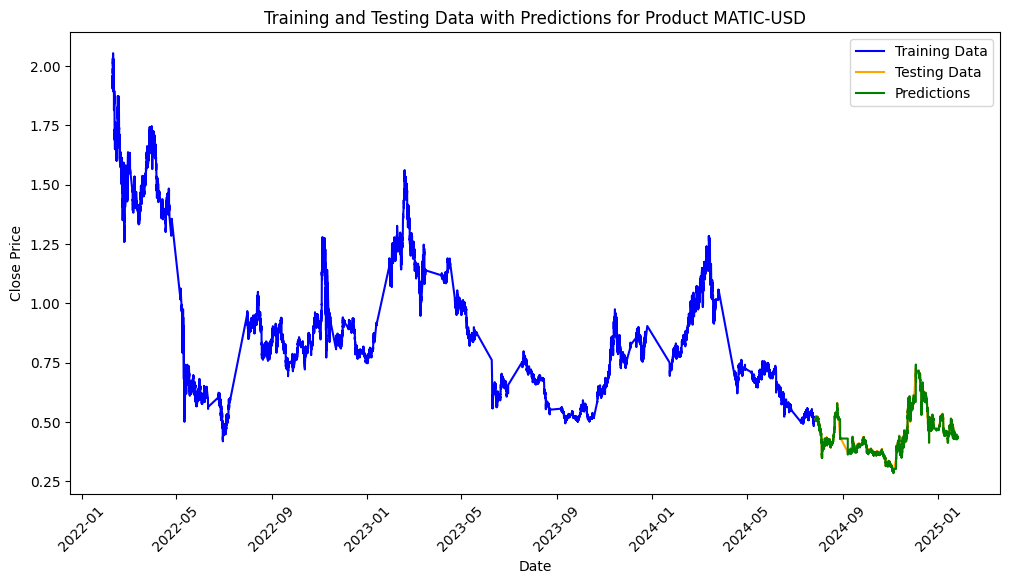

Processing Product: REQ-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1031/1031 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - loss: 0.0016 - val_loss: 1.3024e-04
Epoch 2/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - loss: 6.1480e-04 - val_loss: 5.0476e-05
Epoch 3/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - loss: 4.7343e-04 - val_loss: 1.8680e-04
Epoch 4/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - loss: 4.2316e-04 - val_loss: 1.6394e-04
Epoch 5/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - loss: 3.9664e-04 - val_loss: 3.7276e-05
Epoch 6/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - loss: 3.9694e-04 - val_loss: 1.0544e-04
Epoch 7/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - loss: 3.8278e-04 - val_loss: 2.3887e-04
Epoch 8/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - loss: 3.7868e-04 - val_loss: 4.2531e-05
Epoch 9/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - loss: 3.6292e-04 - val_loss: 4.4152e-05
Epoch 10/15
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - loss: 3.7291e-04 - val_loss: 3.0034e-05
Epoch 11/15
1031/1031 ━━━━━━━━━━━━

322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
RMSE for Product REQ-USD: 0.0010255198932733179


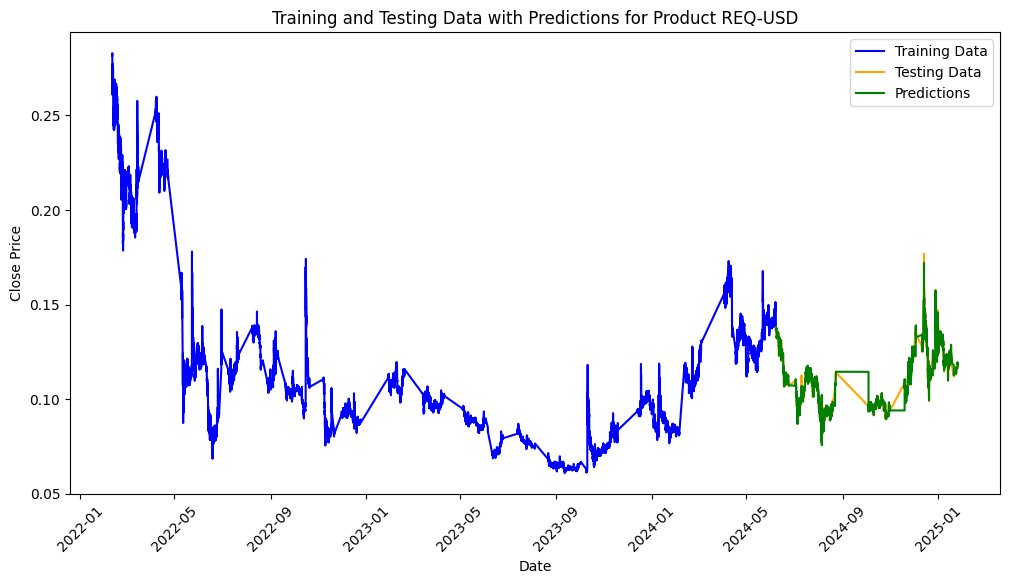

Processing Product: ICP-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 0.0019 - val_loss: 4.3661e-04
Epoch 2/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 5.5170e-04 - val_loss: 0.0013
Epoch 3/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - loss: 4.9634e-04 - val_loss: 1.3404e-04
Epoch 4/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - loss: 4.4752e-04 - val_loss: 2.7454e-04
Epoch 5/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - loss: 4.4526e-04 - val_loss: 2.3534e-04
Epoch 6/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - loss: 4.3784e-04 - val_loss: 1.0431e-04
Epoch 7/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - loss: 4.3619e-04 - val_loss: 8.6901e-05
Epoch 8/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - loss: 4.2323e-04 - val_loss: 0.0013
Epoch 9/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - loss: 4.1182e-04 - val_loss: 6.5009e-05
Epoch 10/15
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - loss: 3.8523e-04 - val_loss: 5.8765e-05
Epoch 11/15
1398/1398 ━━━━━━━━━

437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
RMSE for Product ICP-USD: 0.10278299990007646


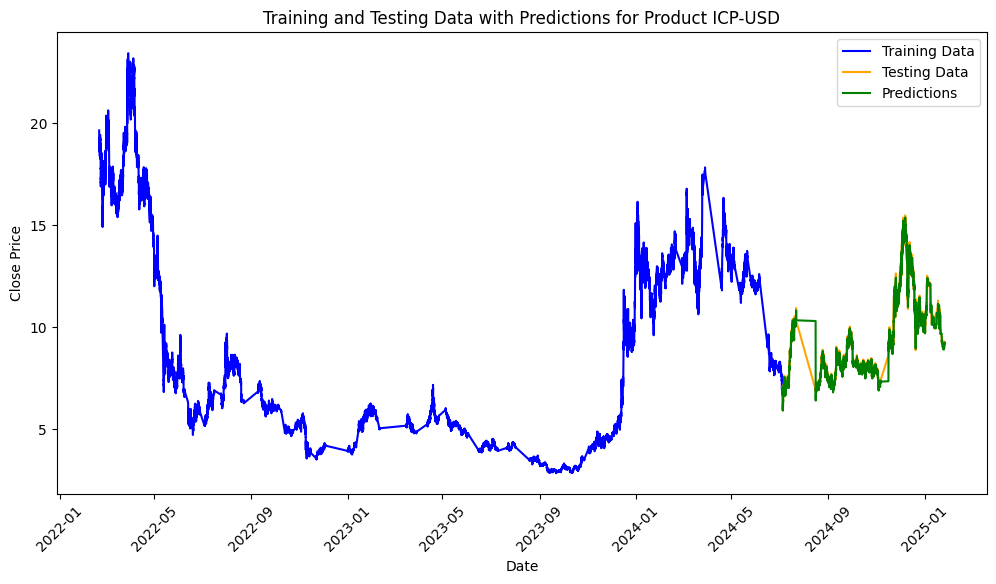

Processing Product: XRP-USD


/var/folders/8h/p_knm3vs33l5gr5cd4bsn9vm0000gn/T/ipykernel_26969/141877876.py:12: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/15


/Users/akshada/Desktop/akshada/DS Projects/ds_proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



599/599 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 0.0033 - val_loss: 2.6577e-04
Epoch 2/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - loss: 0.0011 - val_loss: 2.4926e-04
Epoch 3/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - loss: 8.2180e-04 - val_loss: 2.2976e-04
Epoch 4/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - loss: 5.4652e-04 - val_loss: 2.0130e-04
Epoch 5/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - loss: 3.9578e-04 - val_loss: 2.0425e-04
Epoch 6/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - loss: 3.3564e-04 - val_loss: 2.1955e-04
Epoch 7/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - loss: 3.1214e-04 - val_loss: 1.3342e-04
Epoch 8/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - loss: 2.9375e-04 - val_loss: 1.3391e-04
Epoch 9/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - loss: 2.5986e-04 - val_loss: 2.6825e-04
Epoch 10/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - loss: 2.5853e-04 - val_loss: 1.5275e-04
Epoch 11/15
599/599 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - l

187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
RMSE for Product XRP-USD: 0.5542196221926367


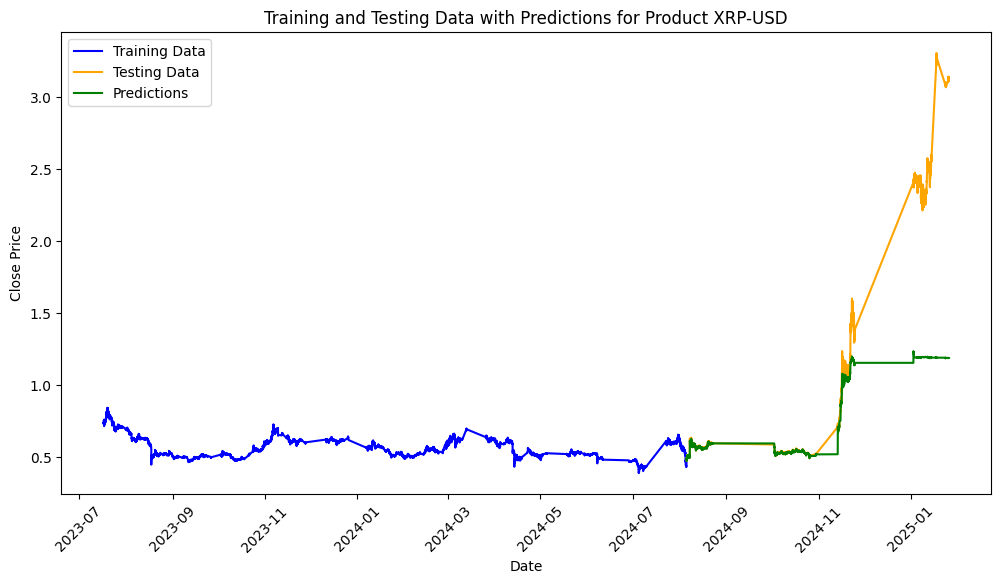

In [12]:
def run_pipeline_for_all_products(csv_path, sequence_length = 192 , epochs=5, batch_size=32, save_dir="models_900"):
    df = pd.read_csv(csv_path)
    product_ids = df['product_id'].unique()

    results = {}
    for product_id in product_ids:
        print(f"Processing Product: {product_id}")
        product_data = load_and_preprocess_data(csv_path, product_id)

        X_train, X_test, y_train, y_test, dates_train, dates_test, scaler_X, scaler_y = split_and_scale_data(
            product_data[['low', 'high', 'open', 'close', 'volume', 'SMA_7', 'EMA_7', 'SMA_30', 'EMA_30']],
            product_data['close'],
            product_data['time'],
            sequence_length
        )

        model = build_and_train_model(X_train, y_train, X_test, y_test, sequence_length, epochs, batch_size)

        save_model_and_scalers(model, scaler_X, scaler_y, product_id, save_dir)

        predictions_df, rmse = make_predictions_and_save(X_test, y_test, dates_test, scaler_y, product_id, save_dir, model)

        plot_results(
            dates_train, scaler_y.inverse_transform(y_train),
            dates_test, scaler_y.inverse_transform(y_test),
            predictions_df['Prediction'], product_id
        )

        plot_with_plotly(dates_test, scaler_y.inverse_transform(y_test), predictions_df['Prediction'])

        results[product_id] = {
            'model': model,
            'predictions': predictions_df,
            'rmse': rmse
        }

    return results

# Example usage
results = run_pipeline_for_all_products("900_gran_data.csv", sequence_length=192, epochs=15, batch_size=32)


In [13]:
results

{'ADA-USD': {'model': <Sequential name=sequential, built=True>,
  'predictions':                      Date  Actual  Prediction
  0     2024-06-06 09:15:00  0.4588    0.455523
  1     2024-06-06 09:30:00  0.4585    0.455674
  2     2024-06-06 09:45:00  0.4581    0.455778
  3     2024-06-06 10:00:00  0.4576    0.455780
  4     2024-06-06 10:15:00  0.4576    0.455659
  ...                   ...     ...         ...
  13223 2025-01-26 04:15:00  0.9862    0.982723
  13224 2025-01-26 04:30:00  0.9846    0.983695
  13225 2025-01-26 04:45:00  0.9839    0.984721
  13226 2025-01-26 05:00:00  0.9838    0.985420
  13227 2025-01-26 05:15:00  0.9838    0.985800
  
  [13228 rows x 3 columns],
  'rmse': np.float64(0.01250046207766479)},
 'DOT-USD': {'model': <Sequential name=sequential_1, built=True>,
  'predictions':                      Date  Actual  Prediction
  0     2024-08-08 08:00:00   4.735    4.817472
  1     2024-08-08 08:15:00   4.734    4.815568
  2     2024-08-08 08:30:00   4.727    4.8144


## Summary

- The pipeline predicts cryptocurrency prices using historical data and LSTM.
- Results are saved for each cryptocurrency, and RMSE is calculated to assess model performance.
- Interactive plots provide insights into the model's predictions versus actual data.
